# Carbon fluxes

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
from dask.distributed import LocalCluster
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools

#import util

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()

### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset>
Dimensions:                           (time: 768, nlat: 384, nlon: 320,
                                       z_t: 60, z_w: 60, lat_aux_grid: 395,
                                       moc_z: 61, d2: 2, z_t_150m: 15,
                                       z_w_bot: 60, z_w_top: 60,
                                       transport_reg: 2, moc_comp: 3,
                                       transport_comp: 5)
Coordinates:
    TLAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                              (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                      (lat_aux_grid) float32 -79.49 ... 90.0
  * moc_z                             (moc_z) float32 0.0 1e+03 ... 5.5e+05
  * time                              (time) object 1958-02-01 00:00:00 ... 2...
  * z_t                               (z_t) float32 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                          (z_t_150m) float32 500.0 ... 1.45e+04
  * z_w                               (z_w) float32 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                           (z_w_bot) float32 1e+03 2e+03 ... 5.5e+05
  * z_w_top                           (z_w_top) float32 0.0 1e+03 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2, transport_reg, moc_comp,
                                transport_comp
Data variables: (12/544)
    ADVS                              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    ANGLE                             (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                            (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                               (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                                ...
    x_graze_mesozoo_zint              (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_mesozoo_zint_100m         (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint             (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    x_graze_microzoo_zint_100m        (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatarag                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    zsatcalc                          (time, nlat, nlon) float32 dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 09:15:38 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting

In [7]:
variables =['FG_CO2','photoC_TOT_zint','POC_FLUX_100m']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Processing - global means in time and space

Pull in the functions we defined in the nutrients notebook...

In [8]:
def year_mean(ds):
    """
    Add a docstring
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    
def global_mean(ds, ds_grid, compute_vars, normalize=True, include_ms=False):
    """
    Compute the global mean on a POP dataset. 
    Return computed quantity in conventional units.
    """

    other_vars = list(set(ds.variables) - set(compute_vars))

    if include_ms: # marginal seas!
        surface_mask = ds_grid.TAREA.where(ds_grid.KMT > 0).fillna(0.)
    else:
        surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.)        
    
    masked_area = {
        v: surface_mask.where(ds[v].notnull()).fillna(0.) 
        for v in compute_vars
    }
    
    with xr.set_options(keep_attrs=True):
        
        dso = xr.Dataset({
            v: (ds[v] * masked_area[v]).sum(['nlat', 'nlon'])
            for v in compute_vars
        })
        
        if normalize:
            dso = xr.Dataset({
                v: dso[v] / masked_area[v].sum(['nlat', 'nlon'])
                for v in compute_vars
            })            
                
    return dso

In [9]:
# Take the long-term mean of our data set, processing years and months separately (improve this comment)

ds = year_mean(ds).mean("year")

### Do some global integrals, to check if our values look reasonable

In [10]:
ds_glb = global_mean(ds, ds_grid, variables,normalize=False).compute()

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

<xarray.Dataset>
Dimensions:          ()
Data variables:
    FG_CO2           float64 2.036
    photoC_TOT_zint  float64 53.16
    POC_FLUX_100m    float64 6.8

## Make some maps

In [11]:
### convert from mmol/m3 cm/s to mmol/m2/d
for var in variables:
    ds[var] = ds[var] * 0.01 * 86400.

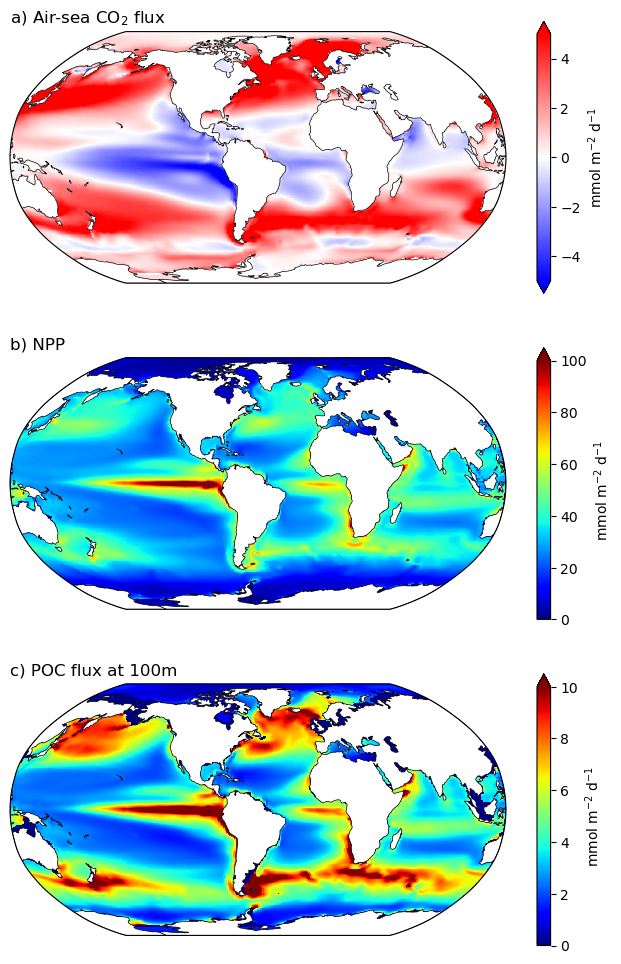

In [12]:
fig = plt.figure(figsize=(8,12))

ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('a) Air-sea CO$_2$ flux', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.FG_CO2)
pc=ax.pcolormesh(lon, lat, field, cmap='bwr',vmin=-5,vmax=5,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='mmol m$^{-2}$ d$^{-1}$')


ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('b) NPP', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=100,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$')

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('c) POC flux at 100m', fontsize=12,loc='left')
lon, lat, field = adjust_pop_grid(lons, lats,  ds.POC_FLUX_100m)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='mmol m$^{-2}$ d$^{-1}$');

And close the Dask cluster we spun up at the beginning.

In [13]:
cluster.close()

2024-01-26 12:53:34,042 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2024-01-26 12:53:34,043 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-26 12:53:34,043 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2024-01-26 12:53:34,044 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2024-01-26 12:53:34,044 - distributed.nanny - WARNING - Worker process still alive after 3.1999995422363288 seconds, killing
2024-01-26 12:53:34,045 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2024-01-26 12:53:34,045 - distributed.nanny - WARNING - Worker process still alive after 3.199999694824219 seconds, killing
2024-01-26 12:53:34,046 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2024-